# Tesla Stock Price Prediction, 365 All At Once
### Second Semester Capstone


In [1]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot
from statistics import mean

# LSTM Application

## Preparing Data

In [2]:
# Loading Preprocessed Data File
df = pd.read_csv("../Data/preprocessed.csv",usecols=['Date','Close','Tesla Trend','Month','Day of the Month','Day of the Week'], parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)

print(df.shape)
df.head()

(2699, 5)


,Close,Tesla Trend,Month,Day of the Month,Day of the Week
Date,,,,,
2010-07-01,4.392,7.00,7,1,3
2010-07-02,3.840,6.09,7,2,4
2010-07-06,3.222,2.10,7,6,1
2010-07-07,3.160,3.78,7,7,2
2010-07-08,3.492,5.60,7,8,3


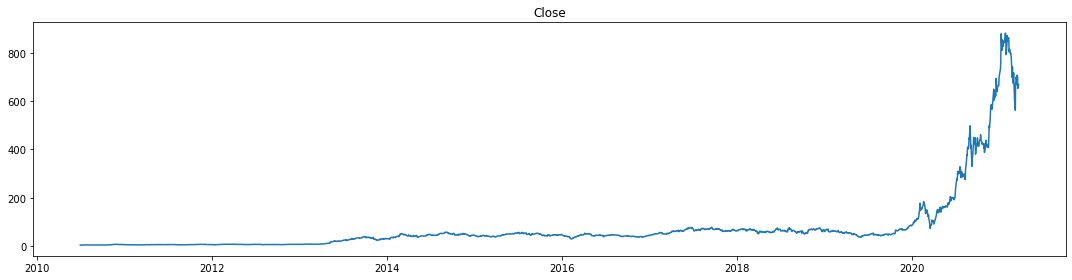

In [3]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(15,4))

pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")

pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [4]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Converting Data for Supervised Learning

In [5]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here since we don't have non-numerical data)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, 365, 365)

# Drop Columns of Variables We Aren't Predicting
# We want only the variable we're predicting for time t
for i in range(1, 365):
    reframed.drop(reframed.loc[:, ('Tesla Trend(t+%i)' %(i)):('Day of the Week(t+%i)' %(i))], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Tesla Trend(t)':'Day of the Week(t)'], axis=1, inplace=True)

print(reframed.shape)
reframed.head()

(1970, 2190)


,Close(t-365),Tesla Trend(t-365),Month(t-365),Day of the Month(t-365),Day of the Week(t-365),Close(t-364),Tesla Trend(t-364),Month(t-364),Day of the Month(t-364),Day of the Week(t-364),...,Close(t+355),Close(t+356),Close(t+357),Close(t+358),Close(t+359),Close(t+360),Close(t+361),Close(t+362),Close(t+363),Close(t+364)
365,0.001400,0.060606,0.545455,0.000000,0.75,0.000773,0.051414,0.545455,0.033333,1.00,...,0.016365,0.015328,0.015692,0.017376,0.017206,0.016851,0.016317,0.016238,0.017485,0.018474
366,0.000773,0.051414,0.545455,0.033333,1.00,0.000070,0.011111,0.545455,0.166667,0.25,...,0.015328,0.015692,0.017376,0.017206,0.016851,0.016317,0.016238,0.017485,0.018474,0.021486
367,0.000070,0.011111,0.545455,0.166667,0.25,0.000000,0.028081,0.545455,0.200000,0.50,...,0.015692,0.017376,0.017206,0.016851,0.016317,0.016238,0.017485,0.018474,0.021486,0.020190
368,0.000000,0.028081,0.545455,0.200000,0.50,0.000377,0.046465,0.545455,0.233333,0.75,...,0.017376,0.017206,0.016851,0.016317,0.016238,0.017485,0.018474,0.021486,0.020190,0.020263
369,0.000377,0.046465,0.545455,0.233333,0.75,0.000364,0.037273,0.545455,0.266667,1.00,...,0.017206,0.016851,0.016317,0.016238,0.017485,0.018474,0.021486,0.020190,0.020263,0.018629


In [6]:
y = reframed.iloc[:,-365:]
x = reframed.iloc[:,:-365]
x_vals = x.values
y_vals = y.values
# split into train, test, and prediction sets
n_predict = 1 # We are predicting 365 days
n_train = floor((len(x_vals)-n_predict) * 0.80) # 80% of the data is currently used for train (can be adjusted)
# split into input and outputs
train_X, train_y = x_vals[:n_train, :], y_vals[:n_train, :]
test_X, test_y = x_vals[n_train:len(x_vals)-n_predict, :], y_vals[n_train:len(y_vals)-n_predict, :]
predict_X, predict_y = x_vals[len(x_vals)-n_predict:, :], y_vals[len(y_vals)-n_predict:, :]
print(predict_X.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(1, 1825)
(1575, 1, 1825) (1575, 365) (394, 1, 1825) (394, 365) (1, 1, 1825) (1, 365)


## Running Model

In [7]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg
#from tensorflow.keras.callbacks import Callback

# Unused
"""
class stopAtLossValue(Callback):
        def on_batch_end(self, batch, logs={}):
            THR = 0.009 #Assign THR with the value at which you want to stop training.
            if logs.get('loss') <= THR:
                 self.model.stop_training = True
"""

"\nclass stopAtLossValue(Callback):\n        def on_batch_end(self, batch, logs={}):\n            THR = 0.009 #Assign THR with the value at which you want to stop training.\n            if logs.get('loss') <= THR:\n                 self.model.stop_training = True\n"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               770400    
_________________________________________________________________
dense (Dense)                (None, 365)               36865     
Total params: 807,265
Trainable params: 807,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
40/40 - 2s - loss: 0.0168 - accuracy: 0.0032 - val_loss: 0.0831 - val_accuracy: 0.0025
Epoch 2/150
40/40 - 0s - loss: 0.0283 - accuracy: 0.0019 - val_loss: 0.0795 - val_accuracy: 0.0051
Epoch 3/150
40/40 - 0s - loss: 0.0200 - accuracy: 0.0038 - val_loss: 0.0781 - val_accuracy: 0.0000e+00
Epoch 4/150
40/40 - 0s - loss: 0.0181 - accuracy: 0.0019 - val_loss: 0.0799 - val_accuracy: 0.0025
Epoch 5/150
40/40 - 0s - loss: 0.0168 - accuracy: 0.0019 - val_loss: 0.0804 - val_accuracy: 0.0152
Epoch 6/150
4

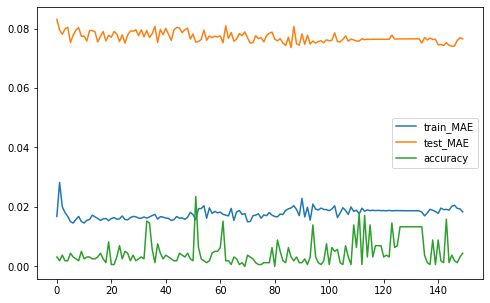

In [8]:
# Design Network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(365, activation="linear", kernel_constraint=NonNeg()))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit network
# epochs = how long you're running it
# batch_size = number of training samples to use in an epoch
history = model.fit(train_X, train_y, epochs=150, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(8,5))
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.legend()
pyplot.show()

### Prediction

In [9]:
# make a prediction
yhat = model.predict(predict_X)
from sklearn.metrics import mean_squared_error
# calculate RMSE

predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
#predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: operands could not be broadcast together with shapes (1,2189) (5,) (1,2189) 

### Metrics

In [ ]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(predict_y, yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(predict_y.mean(axis=1))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 0.407
Normalized RMSE: 1.111


In [ ]:
# Finding the predicted quarterly maximums
predictDates = dates[len(dates)-365:]

q1 = [yhat[0][0:89]]
q2 = [yhat[0][90:179]]
q3 = [yhat[0][180:269]]
q4 = [yhat[0][270:364]]
#maxes = [dates[np.argmax(yhat[0:89], axis=0)]]
#maxes_actual = [dates[np.argmax(predict_y[0:89], axis=0)]]
maxes = [
    predictDates[np.argmax(q1, axis=0)], 
    predictDates[np.argmax(q2, axis=0)+90], 
    predictDates[np.argmax(q3, axis=0)+180], 
    predictDates[np.argmax(q4, axis=0)+270]
]
q1 = [predict_y[0][0:89]]
q2 = [predict_y[0][90:179]]
q3 = [predict_y[0][180:269]]
q4 = [predict_y[0][270:364]]
maxes_actual = [
    predictDates[np.argmax(q1, axis=0)], 
    predictDates[np.argmax(q2, axis=0)+90], 
    predictDates[np.argmax(q3, axis=0)+180], 
    predictDates[np.argmax(q4, axis=0)+270]
]

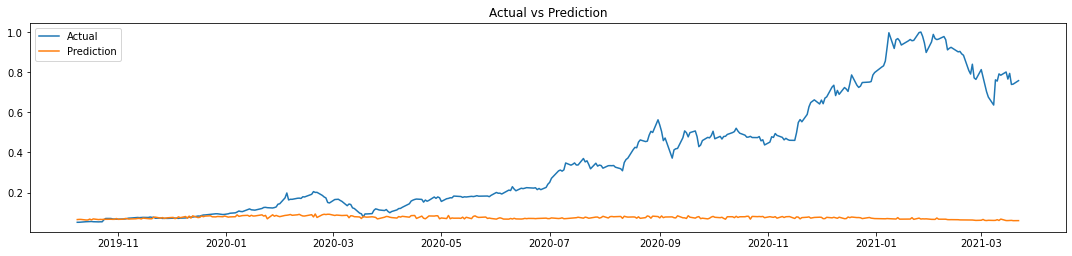

In [ ]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(15,10))
"""
pyplot.subplot(3, 1, 1)
pyplot.plot(predictDates, predict_y[0], color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual with Quarterly Maxes")

pyplot.subplot(3, 1, 2)
pyplot.plot(predictDates, yhat[0], color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction with Quarterly Maxes")"""

pyplot.subplot(3, 1, 3)
pyplot.plot(predictDates, predict_y[0], label="Actual")
pyplot.plot(predictDates, yhat[0], label="Prediction")
pyplot.legend(loc='upper left')
pyplot.title("Actual vs Prediction")

pyplot.tight_layout()
pyplot.show()

In [ ]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i][0]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i][0]))
    print("Diff: %s" %abs((maxes_actual[i][0]-maxes[i][0]).astype('timedelta64[D]')))

Q1 Max: 2019-10-09T00:00:00.000000000
Q1 Actual Max: 2019-10-09T00:00:00.000000000
Diff: 0 days
Q2 Max: 2020-02-19T00:00:00.000000000
Q2 Actual Max: 2020-02-19T00:00:00.000000000
Diff: 0 days
Q3 Max: 2020-06-26T00:00:00.000000000
Q3 Actual Max: 2020-06-26T00:00:00.000000000
Diff: 0 days
Q4 Max: 2020-11-03T00:00:00.000000000
Q4 Actual Max: 2020-11-03T00:00:00.000000000
Diff: 0 days
